# XGBOOST BASELINE for Semeval - Restaurants 2016

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  aspect = df['aspect']
  polarity = df['polarity']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'aspect': aspect,
                    'polarity': polarity})
  
  df2['polarity'] = [x.split(',') for x in df2['polarity']]
  df2['aspect'] = [x.split(',') for x in df2['aspect']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
R16_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalRestaurants_combi16_train.csv")

Overwrite "text" column by applying "appSep" function:

In [5]:
R16_train = changeFormat(R16_train)
R16_train.head()

,text,aspect,polarity
0,[CLS] JUST AWSOME. [SEP],[FOOD#QUALITY],[positive]
1,[CLS] This place is a great bargain. [SEP],[RESTAURANT#PRICES],[positive]
2,[CLS] delicious simple food in nice outdoor at...,"[FOOD#QUALITY, FOOD#STYLE_OPTIONS, AMBIENCE#GE...","[positive, positive, positive]"
3,"[CLS] The service was attentive, yet discreet....",[SERVICE#GENERAL],[positive]
4,"[CLS] Excellent dumplings served amid clean, c...","[FOOD#QUALITY, AMBIENCE#GENERAL]","[positive, positive]"


In [0]:
R16_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalRestaurants_combi16_test.csv")

In [7]:
R16_test = changeFormat(R16_test)
R16_test.head()

,text,aspect,polarity
0,[CLS] The stuff tilapia was horrid...tasted li...,[FOOD#QUALITY],[negative]
1,[CLS] Enjoyed a very nice Caesar Salad while m...,"[FOOD#QUALITY, FOOD#QUALITY]","[positive, positive]"
2,"[CLS] Can't argue about that, but they are cle...",[FOOD#PRICES],[negative]
3,[CLS] Love their drink menu. [SEP],[DRINKS#STYLE_OPTIONS],[positive]
4,[CLS] I have known about this secret for the l...,"[DRINKS#PRICES, FOOD#PRICES, DRINKS#QUALITY, F...","[positive, positive, positive, positive]"


Shape of the train and test data:

In [8]:
R16_train.shape

(1362, 3)

In [9]:
R16_test.shape

(341, 3)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [13]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

Get BERT embeddings for train and test data:

In [0]:
R16_train_embeddings = embed.get_embeddings(R16_train.text, all=False)
R16_test_embeddings = embed.get_embeddings(R16_test.text, all=False)

Plausibility check

In [17]:
# number of vectors 
len(R16_train_embeddings[0])

6

In [18]:
#string is counted letter per letter
len(R16_train['text'][0])

24

In [19]:
# original text
R16_train['text'][0]

'[CLS] JUST AWSOME. [SEP]'

In [20]:
# vectors
R16_train_embeddings[0]

tensor([[-0.2349,  0.1811, -0.0614,  ..., -0.3291,  0.4094,  0.3097],
        [ 0.3669,  0.1237,  0.9153,  ..., -0.1398,  0.4503,  0.7307],
        [-0.7599,  0.9384,  0.6005,  ..., -0.8875,  0.1790, -0.2708],
        [-0.0683,  0.5353,  0.9692,  ..., -0.1806,  0.1226, -0.9209],
        [-0.4697, -0.6516,  0.1647,  ...,  0.7621,  0.4106, -0.5169],
        [ 0.6923,  0.4695, -0.0194,  ...,  0.3259, -0.4199, -0.1693]])

In [21]:
len(R16_test_embeddings[0])

18

In [22]:
R16_test['text'][0]

'[CLS] The stuff tilapia was horrid...tasted like cardboard. [SEP]'

In [0]:
R16_train['embeddings'] = [e[0].numpy() for e in R16_train_embeddings]
R16_test['embeddings'] = [e[0].numpy() for e in R16_test_embeddings]

##**XGBOOST Baseline Model for Aspect**

In [24]:
R16_aspect = MultiLabelBinarizer()
R16_aspect.fit(R16_train.aspect)
R16_aspect.classes_

array(['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY',
       'DRINKS#STYLE_OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY',
       'FOOD#STYLE_OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL',
       'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
      dtype=object)

In [25]:
y_R16_train_aspect = R16_aspect.transform(R16_train.aspect)
y_R16_test_aspect = R16_aspect.transform(R16_test.aspect)
y_R16_train_aspect[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [26]:
R16_xgb_aspect = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
R16_xgb_aspect.fit(np.array(list(R16_train.embeddings)), y_R16_train_aspect)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [27]:
R16_aspect_report = classification_report(y_R16_test_aspect, R16_xgb_aspect.predict(np.array(list(R16_test.embeddings))),
                            target_names=R16_aspect.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

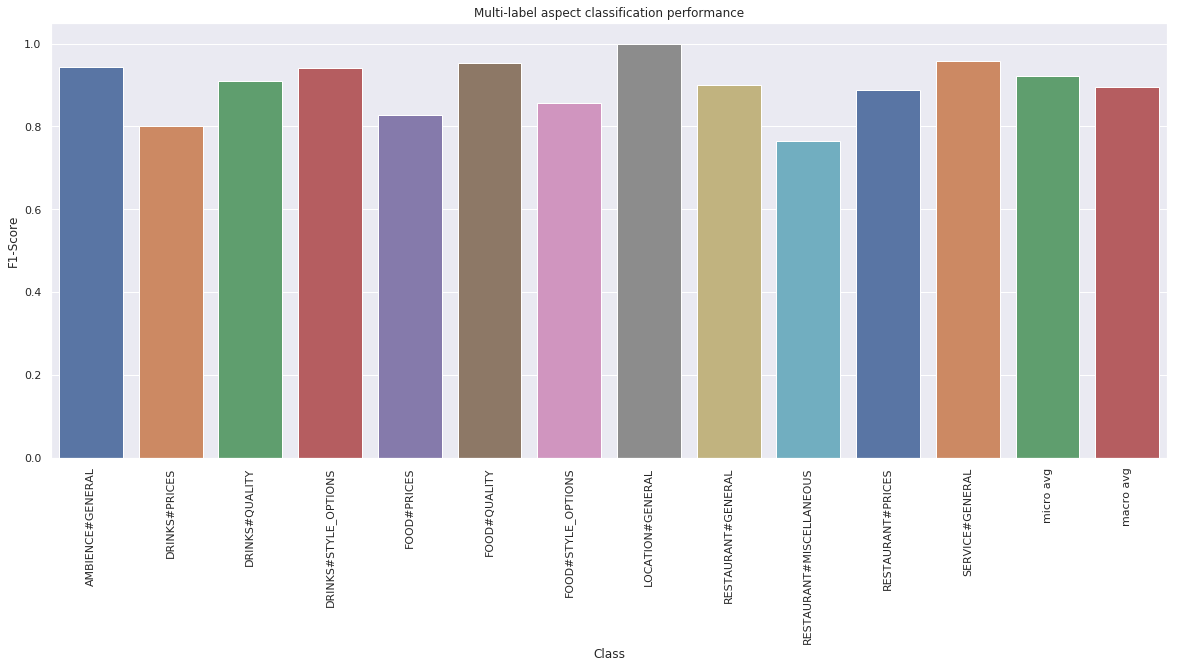

In [28]:
R16_f1s_aspect = []
for key in R16_aspect_report.keys():
    R16_f1s_aspect.append(R16_aspect_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(R16_aspect_report.keys())[:-2], R16_f1s_aspect[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

[Text(0.942528735632184, 0, '0.94'),
 Text(0.8000000000000002, 1, '0.80'),
 Text(0.9090909090909091, 2, '0.91'),
 Text(0.9411764705882353, 3, '0.94'),
 Text(0.8275862068965517, 4, '0.83'),
 Text(0.9523809523809523, 5, '0.95'),
 Text(0.8571428571428571, 6, '0.86'),
 Text(1.0, 7, '1.00'),
 Text(0.9012345679012346, 8, '0.90'),
 Text(0.7647058823529412, 9, '0.76'),
 Text(0.888888888888889, 10, '0.89'),
 Text(0.9570552147239264, 11, '0.96'),
 Text(0.9221967963386727, 12, '0.92'),
 Text(0.8951492237998901, 13, '0.90')]

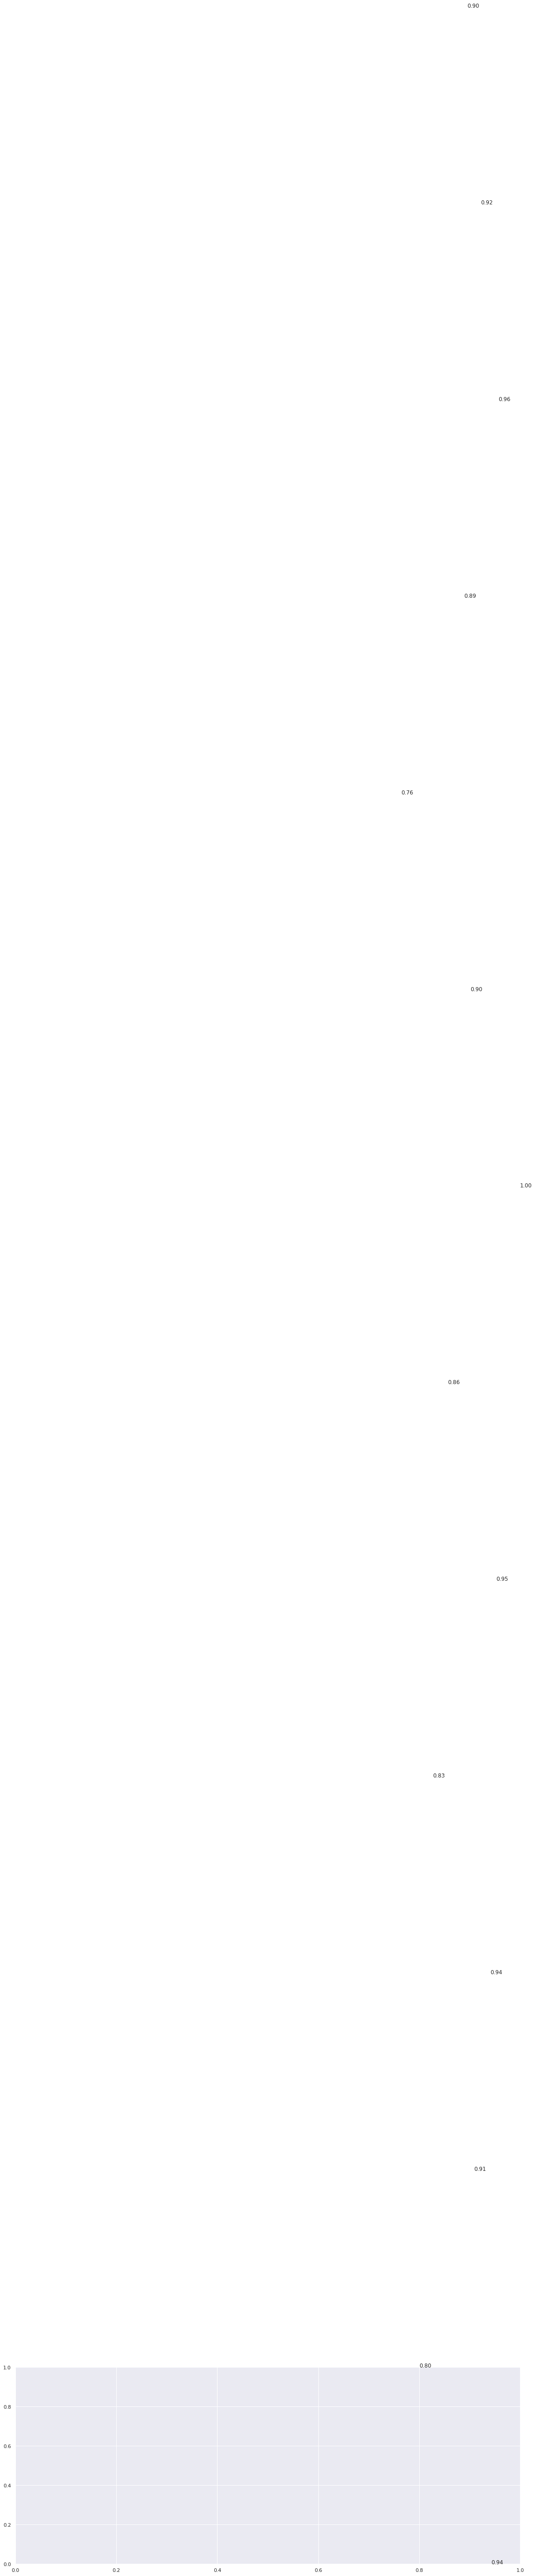

In [30]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(R16_f1s_aspect[:-2])]

##**XGBOOST Baseline Model for Polarity**

In [31]:
R16_polarity = MultiLabelBinarizer()
R16_polarity.fit(R16_train.polarity)
R16_polarity.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [32]:
y_R16_train_polarity = R16_polarity.transform(R16_train.polarity)
y_R16_test_polarity = R16_polarity.transform(R16_test.polarity)
y_R16_train_polarity[3]

array([0, 0, 1])

In [33]:
R16_xgb_polarity = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                                 learning_rate=0.05, n_jobs=24, verbosity=1, min_child_weight=50,
                                                 scale_pos_weight=6, base_score=0.3))
R16_xgb_polarity.fit(np.array(list(R16_train.embeddings)), y_R16_train_polarity)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.3, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=50, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [0]:
R16_polarity_report = classification_report(y_R16_test_polarity, R16_xgb_polarity.predict(np.array(list(R16_test.embeddings))),
                            target_names=R16_polarity.classes_, output_dict=True)

Text(0.5, 1.0, 'Multi-label polarity classification performance')

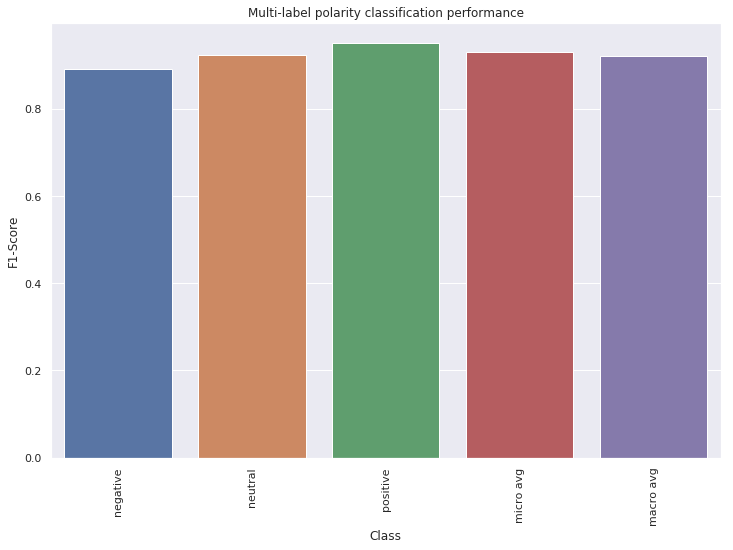

In [35]:
R16_f1s_polarity = []
for key in R16_polarity_report.keys():
    R16_f1s_polarity.append(R16_polarity_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(list(R16_polarity_report.keys())[:-2], R16_f1s_polarity[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label polarity classification performance')

[Text(0.8916666666666666, 0, '0.89'),
 Text(0.923076923076923, 1, '0.92'),
 Text(0.9504950495049505, 2, '0.95'),
 Text(0.9311224489795918, 3, '0.93'),
 Text(0.9217462130828467, 4, '0.92')]

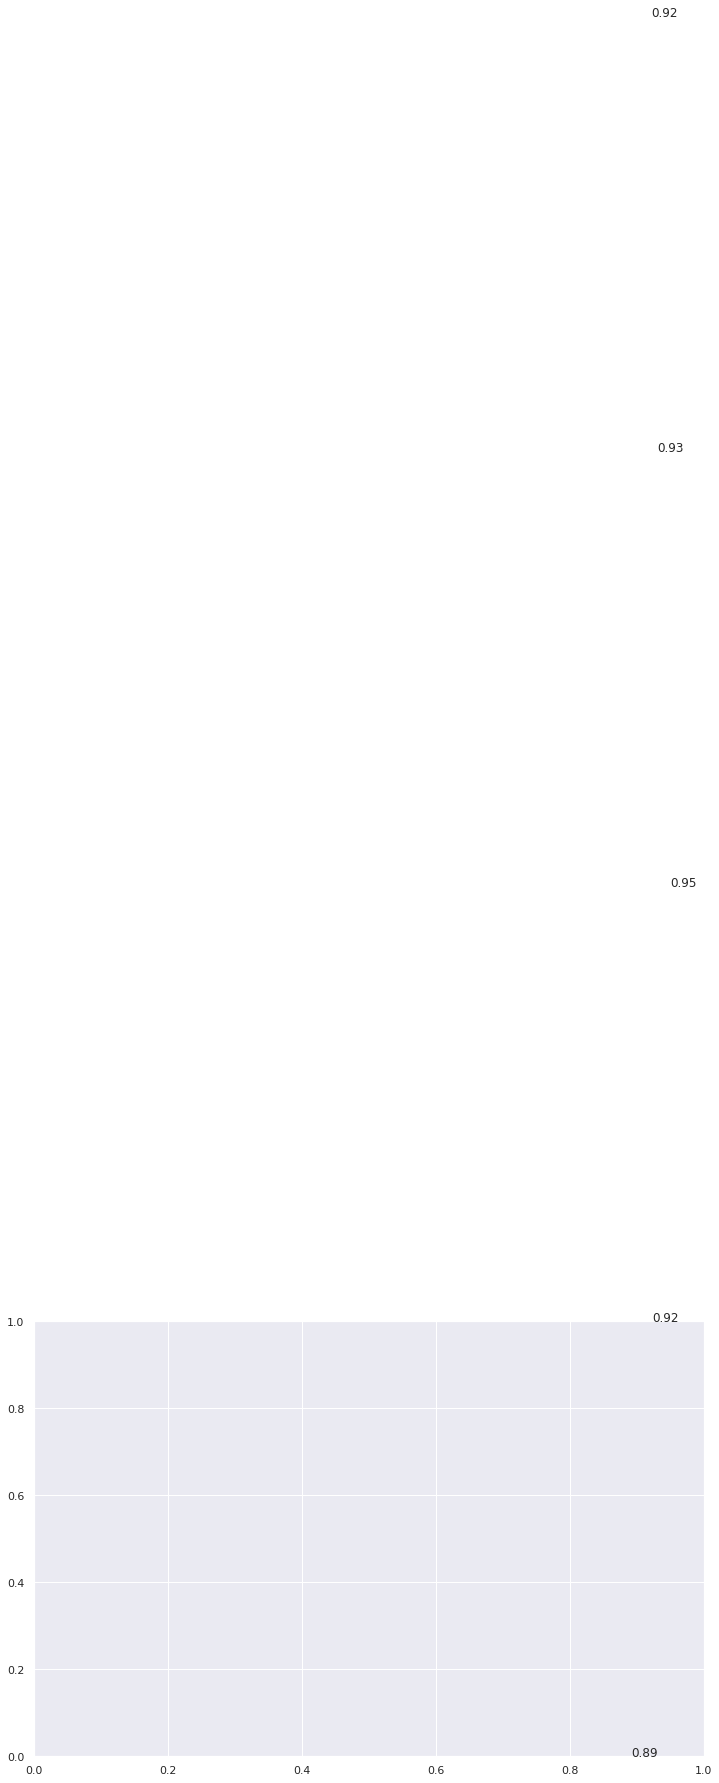

In [36]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(R16_f1s_polarity[:-2])]